In [1]:
# Cell 1: Install HuggingFace Transformers, Datasets, and Torch (if not installed)
!pip install --quiet torch torchvision
!pip install --quiet transformers datasets timm
!pip install --quiet huggingface_hub --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

In [2]:
# Cell 2: Imports and Device Setup

import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset, DatasetDict
from torchvision import transforms
import pandas as pd
import os

# Check device (should be CUDA on Kaggle GPU notebook)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-07-27 14:15:20.856483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753625721.207664      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753625721.311447      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [3]:
# Cell 3: List all .tif images and their labels from EuroSATallBands

import glob

# Path to EuroSATallBands (Change this if your path is different)
BANDS_PATH = "/kaggle/input/eurosat16"

class_names = sorted(os.listdir(BANDS_PATH))
data = []

for class_name in class_names:
    class_folder = os.path.join(BANDS_PATH, class_name)
    tiffs = glob.glob(os.path.join(class_folder, "*.tif"))
    for tif in tiffs:
        data.append({"image_path": tif, "label": class_name})

df = pd.DataFrame(data)
print(df.head())
print(f"Total samples: {len(df)}")
print(f"Classes: {df['label'].unique()}")

                                          image_path       label
0  /kaggle/input/eurosat16/AnnualCrop/AnnualCrop_...  AnnualCrop
1  /kaggle/input/eurosat16/AnnualCrop/AnnualCrop_...  AnnualCrop
2  /kaggle/input/eurosat16/AnnualCrop/AnnualCrop_...  AnnualCrop
3  /kaggle/input/eurosat16/AnnualCrop/AnnualCrop_...  AnnualCrop
4  /kaggle/input/eurosat16/AnnualCrop/AnnualCrop_...  AnnualCrop
Total samples: 27597
Classes: ['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


In [4]:
# Cell 4: Encode labels and split dataframe

from sklearn.model_selection import train_test_split

# Create label mapping
label2id = {name: i for i, name in enumerate(sorted(df['label'].unique()))}
id2label = {v: k for k, v in label2id.items()}

df['label_id'] = df['label'].map(label2id)

# Stratified split
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_id'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label_id'])

print(f"Train: {len(df_train)}\nVal: {len(df_val)}\nTest: {len(df_test)}")
print("Label mapping:", label2id)

Train: 22077
Val: 2760
Test: 2760
Label mapping: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [5]:
# Cell 5: Install rasterio for reading .tif images
!pip install --quiet rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.7 MB/s eta 0:00:00


In [6]:
# Cell 6 (Combined): EuroSAT prithvi-6-band Dataset definition, load test, one sample

import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np

class EuroSATPrithvi6BandDataset(Dataset):
    def __init__(self, df, label2id, transform=None):
        self.df = df.reset_index(drop=True)
        self.label2id = label2id
        self.transform = transform
        # Blue, Green, Red, Narrow NIR, SWIR1, SWIR2 = [1,2,3,8,10,11]
        self.band_indices = [1, 2, 3, 8, 10, 11]  

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        image_path = record['image_path']
        label = self.label2id[record['label']]

        with rasterio.open(image_path) as src:
            img = src.read()  # (13, H, W)
            img = img[self.band_indices, :, :]  # select only 6 needed bands
            img = img.astype(np.float32)
            img = img / img.max() if img.max() > 1 else img   # normalize to [0,1]

        if self.transform:
            img = self.transform(torch.from_numpy(img))

        return {
            "pixel_values": torch.from_numpy(img).float(),  # (6, H, W)
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Instantiate for train/val/test (transforms will be handled later if needed)
train_dataset = EuroSATPrithvi6BandDataset(df_train, label2id)
val_dataset   = EuroSATPrithvi6BandDataset(df_val, label2id)
test_dataset  = EuroSATPrithvi6BandDataset(df_test, label2id)

# Print shapes and label for a sample
sample = train_dataset[0]
print("Shape of 6-band img:", sample['pixel_values'].shape)
print("Label (numeric):", sample['labels'])

Shape of 6-band img: torch.Size([6, 16, 16])
Label (numeric): tensor(4)


In [7]:
import sys
import importlib.util
import torch
import json
import os

MODEL_DIR = "/kaggle/input/models"

# Import model code
spec = importlib.util.spec_from_file_location("prithvi_mae", os.path.join(MODEL_DIR, "prithvi_mae.py"))
prithvi_mae = importlib.util.module_from_spec(spec)
sys.modules["prithvi_mae"] = prithvi_mae
spec.loader.exec_module(prithvi_mae)

# Load config.json
with open(os.path.join(MODEL_DIR, "config.json")) as f:
    config = json.load(f)

print("Config loaded:", config['pretrained_cfg'])

# Instantiate the model using only pretrained_cfg (not the outer dict)
mae_model = prithvi_mae.PrithviMAE(**config['pretrained_cfg'])
print("Instantiated PrithviMAE.")

# Load weights
ckpt = torch.load(os.path.join(MODEL_DIR, "Prithvi_EO_V2_300M.pt"), map_location="cpu")
mae_model.load_state_dict(ckpt, strict=False)
print("Loaded pretrained weights.")

Config loaded: {'img_size': 224, 'num_frames': 4, 'patch_size': [1, 16, 16], 'in_chans': 6, 'embed_dim': 1024, 'depth': 24, 'num_heads': 16, 'decoder_embed_dim': 512, 'decoder_depth': 8, 'decoder_num_heads': 16, 'mlp_ratio': 4, 'coords_encoding': [], 'coords_scale_learn': False, 'mask_ratio': 0.75, 'norm_pix_loss': False, 'bands': ['B02', 'B03', 'B04', 'B05', 'B06', 'B07'], 'mean': [1087.0, 1342.0, 1433.0, 2734.0, 1958.0, 1363.0], 'std': [2248.0, 2179.0, 2178.0, 1850.0, 1242.0, 1049.0], 'origin_url': 'https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-2.0-300M', 'paper_ids': 'arXiv:X.X'}
Instantiated PrithviMAE.
Loaded pretrained weights.


In [8]:
# Cell 8: Define a Prithvi EuroSAT classifier model

import torch.nn as nn
import torch

class PrithviEuroSATClassifier(nn.Module):
    def __init__(self, pretrained_mae, num_classes):
        super().__init__()
        self.encoder = pretrained_mae.encoder  # Use the encoder for features
        self.norm = pretrained_mae.encoder.norm  # Final norm layer after encoder
        self.cls_head = nn.Linear(self.encoder.embed_dim, num_classes)
    
    def forward(self, x):
        # The encoder expects shape [B, C, T, H, W].
        # We use T=1 (single temporal step) for EuroSAT images:
        if len(x.shape) == 4:
            # Add time dimension (T=1)
            x = x.unsqueeze(2)
        features = self.encoder(x)[0]  # [B, num_tokens+1, embed_dim], first is CLS token
        cls_tok = features[:, 0]       # CLS token ([B, embed_dim])
        logits = self.cls_head(cls_tok)
        return logits

# Instantiate your classifier
NUM_CLASSES = len(label2id)
model = PrithviEuroSATClassifier(mae_model, num_classes=NUM_CLASSES)
model = model.to(device)

print("EuroSAT classifier ready:", model)

EuroSAT classifier ready: PrithviEuroSATClassifier(
  (encoder): PrithviViT(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(6, 1024, kernel_size=(1, 16, 16), stride=(1, 16, 16))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False

In [9]:
# Cell 9: DataLoaders, Loss, Optimizer

from torch.utils.data import DataLoader

BATCH_SIZE = 512  # Adjust as Kaggle GPU memory allows, 16 or 8 is usually safe
NUM_WORKERS = 8  # You can try 4 for faster I/O if RAM allows

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

print("DataLoaders, Loss, and Optimizer created.")

DataLoaders, Loss, and Optimizer created.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
import types

def patched_forward(self, x, temporal_coords=None, location_coords=None, mask_ratio=0.75):
    if len(x.shape) == 4 and self.patch_embed.input_size[0] == 1:
        x = x.unsqueeze(2)
    sample_shape = x.shape[-3:]
    x = self.patch_embed(x)
    pos_embed = self.interpolate_pos_encoding(sample_shape)
    pos_embed = pos_embed.to(x.device)  # <--- Core fix: move pos_embed to correct device!
    x = x + pos_embed[:, 1:, :]
    if self.temporal_encoding and temporal_coords is not None:
        num_tokens_per_frame = x.shape[1] // self.num_frames
        temporal_encoding = self.temporal_embed_enc(temporal_coords, num_tokens_per_frame)
        x = x + temporal_encoding
    if self.location_encoding and location_coords is not None:
        location_encoding = self.location_embed_enc(location_coords)
        x = x + location_encoding
    x, mask, ids_restore = self.random_masking(x, mask_ratio)
    cls_token = self.cls_token + pos_embed[:, :1, :]
    cls_tokens = cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    for block in self.blocks:
        x = block(x)
    x = self.norm(x)
    return x, mask, ids_restore

# Patch your model's encoder:
model.encoder.forward = types.MethodType(patched_forward, model.encoder)

Epoch 1 [Train]: 100%|██████████| 44/44 [01:18<00:00,  1.79s/it]


Epoch 1 | Train Loss: 2.3286 | Train Acc: 0.1166


Epoch 1 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 1 | Val Loss: 2.3057 | Val Acc: 0.1087
Saved new best model.


Epoch 2 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 2 | Train Loss: 2.3022 | Train Acc: 0.1206


Epoch 2 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 2 | Val Loss: 2.2962 | Val Acc: 0.1304
Saved new best model.


Epoch 3 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 3 | Train Loss: 2.3018 | Train Acc: 0.1212


Epoch 3 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 3 | Val Loss: 2.2932 | Val Acc: 0.1304


Epoch 4 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 4 | Train Loss: 2.2959 | Train Acc: 0.1278


Epoch 4 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 4 | Val Loss: 2.3025 | Val Acc: 0.1304


Epoch 5 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 5 | Train Loss: 2.3003 | Train Acc: 0.1225


Epoch 5 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Epoch 5 | Val Loss: 2.3009 | Val Acc: 0.1304


Epoch 6 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch 6 | Train Loss: 2.2993 | Train Acc: 0.1185


Epoch 6 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


Epoch 6 | Val Loss: 2.2986 | Val Acc: 0.1087


Epoch 7 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 7 | Train Loss: 2.2986 | Train Acc: 0.1237


Epoch 7 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 7 | Val Loss: 2.3006 | Val Acc: 0.1304


Epoch 8 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 8 | Train Loss: 2.2976 | Train Acc: 0.1238


Epoch 8 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 8 | Val Loss: 2.2975 | Val Acc: 0.1087


Epoch 9 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 9 | Train Loss: 2.2951 | Train Acc: 0.1287


Epoch 9 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


Epoch 9 | Val Loss: 2.2963 | Val Acc: 0.1304


Epoch 10 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 10 | Train Loss: 2.2981 | Train Acc: 0.1219


Epoch 10 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 10 | Val Loss: 2.2979 | Val Acc: 0.1304


Epoch 11 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 11 | Train Loss: 2.2951 | Train Acc: 0.1272


Epoch 11 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 11 | Val Loss: 2.2931 | Val Acc: 0.1304


Epoch 12 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 12 | Train Loss: 2.2958 | Train Acc: 0.1251


Epoch 12 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 12 | Val Loss: 2.2956 | Val Acc: 0.1087


Epoch 13 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 13 | Train Loss: 2.2981 | Train Acc: 0.1232


Epoch 13 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 13 | Val Loss: 2.2951 | Val Acc: 0.1304


Epoch 14 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 14 | Train Loss: 2.2967 | Train Acc: 0.1252


Epoch 14 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 14 | Val Loss: 2.2959 | Val Acc: 0.1304


Epoch 15 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 15 | Train Loss: 2.2949 | Train Acc: 0.1303


Epoch 15 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 15 | Val Loss: 2.2946 | Val Acc: 0.1304


Epoch 16 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 16 | Train Loss: 2.2948 | Train Acc: 0.1249


Epoch 16 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 16 | Val Loss: 2.2941 | Val Acc: 0.1304


Epoch 17 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 17 | Train Loss: 2.2955 | Train Acc: 0.1271


Epoch 17 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 17 | Val Loss: 2.2926 | Val Acc: 0.1304


Epoch 18 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 18 | Train Loss: 2.2956 | Train Acc: 0.1263


Epoch 18 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 18 | Val Loss: 2.2948 | Val Acc: 0.1087


Epoch 19 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 19 | Train Loss: 2.2956 | Train Acc: 0.1226


Epoch 19 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


Epoch 19 | Val Loss: 2.2944 | Val Acc: 0.1304


Epoch 20 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 20 | Train Loss: 2.2954 | Train Acc: 0.1270


Epoch 20 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 20 | Val Loss: 2.2938 | Val Acc: 0.1087


Epoch 21 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 21 | Train Loss: 2.2953 | Train Acc: 0.1195


Epoch 21 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 21 | Val Loss: 2.2936 | Val Acc: 0.1087


Epoch 22 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 22 | Train Loss: 2.2946 | Train Acc: 0.1281


Epoch 22 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 22 | Val Loss: 2.2932 | Val Acc: 0.1304


Epoch 23 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 23 | Train Loss: 2.2949 | Train Acc: 0.1228


Epoch 23 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 23 | Val Loss: 2.2969 | Val Acc: 0.1304


Epoch 24 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 24 | Train Loss: 2.2949 | Train Acc: 0.1245


Epoch 24 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 24 | Val Loss: 2.2953 | Val Acc: 0.1304


Epoch 25 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 25 | Train Loss: 2.2944 | Train Acc: 0.1288


Epoch 25 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 25 | Val Loss: 2.2929 | Val Acc: 0.1087


Epoch 26 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 26 | Train Loss: 2.2949 | Train Acc: 0.1240


Epoch 26 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 26 | Val Loss: 2.2935 | Val Acc: 0.1087


Epoch 27 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 27 | Train Loss: 2.2942 | Train Acc: 0.1255


Epoch 27 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 27 | Val Loss: 2.2937 | Val Acc: 0.1304


Epoch 28 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 28 | Train Loss: 2.2937 | Train Acc: 0.1281


Epoch 28 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 28 | Val Loss: 2.2947 | Val Acc: 0.1304


Epoch 29 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 29 | Train Loss: 2.2934 | Train Acc: 0.1289


Epoch 29 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 29 | Val Loss: 2.2941 | Val Acc: 0.1304


Epoch 30 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 30 | Train Loss: 2.2940 | Train Acc: 0.1264


Epoch 30 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 30 | Val Loss: 2.2947 | Val Acc: 0.1304


Epoch 31 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 31 | Train Loss: 2.2938 | Train Acc: 0.1281


Epoch 31 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Epoch 31 | Val Loss: 2.2950 | Val Acc: 0.1087


Epoch 32 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 32 | Train Loss: 2.2936 | Train Acc: 0.1248


Epoch 32 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Epoch 32 | Val Loss: 2.2920 | Val Acc: 0.1304


Epoch 33 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 33 | Train Loss: 2.2950 | Train Acc: 0.1265


Epoch 33 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Epoch 33 | Val Loss: 2.2945 | Val Acc: 0.1304


Epoch 34 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 34 | Train Loss: 2.2943 | Train Acc: 0.1269


Epoch 34 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 34 | Val Loss: 2.2941 | Val Acc: 0.1087


Epoch 35 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 35 | Train Loss: 2.2949 | Train Acc: 0.1272


Epoch 35 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 35 | Val Loss: 2.2932 | Val Acc: 0.1304


Epoch 36 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 36 | Train Loss: 2.2940 | Train Acc: 0.1244


Epoch 36 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 36 | Val Loss: 2.2937 | Val Acc: 0.1087


Epoch 37 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 37 | Train Loss: 2.2946 | Train Acc: 0.1258


Epoch 37 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 37 | Val Loss: 2.2936 | Val Acc: 0.1304


Epoch 38 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 38 | Train Loss: 2.2943 | Train Acc: 0.1271


Epoch 38 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 38 | Val Loss: 2.2921 | Val Acc: 0.1304


Epoch 39 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 39 | Train Loss: 2.2929 | Train Acc: 0.1245


Epoch 39 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 39 | Val Loss: 2.2919 | Val Acc: 0.1304


Epoch 40 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 40 | Train Loss: 2.2939 | Train Acc: 0.1275


Epoch 40 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


Epoch 40 | Val Loss: 2.2943 | Val Acc: 0.1087


Epoch 41 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 41 | Train Loss: 2.2933 | Train Acc: 0.1297


Epoch 41 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch 41 | Val Loss: 2.2939 | Val Acc: 0.1304


Epoch 42 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 42 | Train Loss: 2.2939 | Train Acc: 0.1303


Epoch 42 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 42 | Val Loss: 2.2930 | Val Acc: 0.1304


Epoch 43 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 43 | Train Loss: 2.2935 | Train Acc: 0.1275


Epoch 43 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 43 | Val Loss: 2.2918 | Val Acc: 0.1304


Epoch 44 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch 44 | Train Loss: 2.2929 | Train Acc: 0.1303


Epoch 44 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 44 | Val Loss: 2.2934 | Val Acc: 0.1304


Epoch 45 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 45 | Train Loss: 2.2934 | Train Acc: 0.1231


Epoch 45 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 45 | Val Loss: 2.2919 | Val Acc: 0.1304


Epoch 46 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 46 | Train Loss: 2.2930 | Train Acc: 0.1303


Epoch 46 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Epoch 46 | Val Loss: 2.2935 | Val Acc: 0.1304


Epoch 47 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 47 | Train Loss: 2.2933 | Train Acc: 0.1286


Epoch 47 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 47 | Val Loss: 2.2942 | Val Acc: 0.1304


Epoch 48 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 48 | Train Loss: 2.2938 | Train Acc: 0.1283


Epoch 48 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 48 | Val Loss: 2.2923 | Val Acc: 0.1304


Epoch 49 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.50it/s]


Epoch 49 | Train Loss: 2.2934 | Train Acc: 0.1269


Epoch 49 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]


Epoch 49 | Val Loss: 2.2938 | Val Acc: 0.1304


Epoch 50 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 50 | Train Loss: 2.2931 | Train Acc: 0.1303


Epoch 50 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 50 | Val Loss: 2.2921 | Val Acc: 0.1304


Epoch 51 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 51 | Train Loss: 2.2927 | Train Acc: 0.1303


Epoch 51 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 51 | Val Loss: 2.2918 | Val Acc: 0.1304


Epoch 52 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 52 | Train Loss: 2.2932 | Train Acc: 0.1251


Epoch 52 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 52 | Val Loss: 2.2924 | Val Acc: 0.1304


Epoch 53 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 53 | Train Loss: 2.2929 | Train Acc: 0.1303


Epoch 53 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 53 | Val Loss: 2.2915 | Val Acc: 0.1304


Epoch 54 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 54 | Train Loss: 2.2935 | Train Acc: 0.1303


Epoch 54 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 54 | Val Loss: 2.2923 | Val Acc: 0.1304


Epoch 55 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 55 | Train Loss: 2.2929 | Train Acc: 0.1289


Epoch 55 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 55 | Val Loss: 2.2934 | Val Acc: 0.1304


Epoch 56 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 56 | Train Loss: 2.2935 | Train Acc: 0.1292


Epoch 56 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 56 | Val Loss: 2.2944 | Val Acc: 0.1304


Epoch 57 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 57 | Train Loss: 2.2945 | Train Acc: 0.1270


Epoch 57 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 57 | Val Loss: 2.2929 | Val Acc: 0.1304


Epoch 58 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 58 | Train Loss: 2.2926 | Train Acc: 0.1303


Epoch 58 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 58 | Val Loss: 2.2929 | Val Acc: 0.1304


Epoch 59 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 59 | Train Loss: 2.2928 | Train Acc: 0.1303


Epoch 59 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 59 | Val Loss: 2.2913 | Val Acc: 0.1304


Epoch 60 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.49it/s]


Epoch 60 | Train Loss: 2.2929 | Train Acc: 0.1280


Epoch 60 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


Epoch 60 | Val Loss: 2.2931 | Val Acc: 0.1304


Epoch 61 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch 61 | Train Loss: 2.2926 | Train Acc: 0.1283


Epoch 61 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 61 | Val Loss: 2.2935 | Val Acc: 0.1304


Epoch 62 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 62 | Train Loss: 2.2933 | Train Acc: 0.1303


Epoch 62 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 62 | Val Loss: 2.2918 | Val Acc: 0.1304


Epoch 63 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 63 | Train Loss: 2.2927 | Train Acc: 0.1286


Epoch 63 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 63 | Val Loss: 2.2921 | Val Acc: 0.1304


Epoch 64 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 64 | Train Loss: 2.2925 | Train Acc: 0.1257


Epoch 64 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 64 | Val Loss: 2.2916 | Val Acc: 0.1304


Epoch 65 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 65 | Train Loss: 2.2921 | Train Acc: 0.1303


Epoch 65 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 65 | Val Loss: 2.2922 | Val Acc: 0.1304


Epoch 66 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 66 | Train Loss: 2.2934 | Train Acc: 0.1266


Epoch 66 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 66 | Val Loss: 2.2927 | Val Acc: 0.1304


Epoch 67 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 67 | Train Loss: 2.2923 | Train Acc: 0.1303


Epoch 67 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 67 | Val Loss: 2.2918 | Val Acc: 0.1304


Epoch 68 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch 68 | Train Loss: 2.2928 | Train Acc: 0.1303


Epoch 68 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch 68 | Val Loss: 2.2920 | Val Acc: 0.1304


Epoch 69 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 69 | Train Loss: 2.2927 | Train Acc: 0.1266


Epoch 69 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 69 | Val Loss: 2.2916 | Val Acc: 0.1304


Epoch 70 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 70 | Train Loss: 2.2923 | Train Acc: 0.1303


Epoch 70 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 70 | Val Loss: 2.2916 | Val Acc: 0.1304


Epoch 71 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 71 | Train Loss: 2.2929 | Train Acc: 0.1303


Epoch 71 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 71 | Val Loss: 2.2929 | Val Acc: 0.1304


Epoch 72 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 72 | Train Loss: 2.2925 | Train Acc: 0.1303


Epoch 72 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 72 | Val Loss: 2.2922 | Val Acc: 0.1304


Epoch 73 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.47it/s]


Epoch 73 | Train Loss: 2.2928 | Train Acc: 0.1287


Epoch 73 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 73 | Val Loss: 2.2934 | Val Acc: 0.1304


Epoch 74 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 74 | Train Loss: 2.2928 | Train Acc: 0.1303


Epoch 74 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Epoch 74 | Val Loss: 2.2918 | Val Acc: 0.1304


Epoch 75 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 75 | Train Loss: 2.2930 | Train Acc: 0.1303


Epoch 75 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Epoch 75 | Val Loss: 2.2924 | Val Acc: 0.1304


Epoch 76 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 76 | Train Loss: 2.2925 | Train Acc: 0.1303


Epoch 76 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 76 | Val Loss: 2.2929 | Val Acc: 0.1304


Epoch 77 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 77 | Train Loss: 2.2934 | Train Acc: 0.1303


Epoch 77 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 77 | Val Loss: 2.2914 | Val Acc: 0.1304


Epoch 78 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 78 | Train Loss: 2.2920 | Train Acc: 0.1303


Epoch 78 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 78 | Val Loss: 2.2921 | Val Acc: 0.1304


Epoch 79 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 79 | Train Loss: 2.2928 | Train Acc: 0.1303


Epoch 79 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 79 | Val Loss: 2.2918 | Val Acc: 0.1304


Epoch 80 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 80 | Train Loss: 2.2921 | Train Acc: 0.1303


Epoch 80 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 80 | Val Loss: 2.2917 | Val Acc: 0.1304


Epoch 81 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 81 | Train Loss: 2.2922 | Train Acc: 0.1303


Epoch 81 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 81 | Val Loss: 2.2919 | Val Acc: 0.1304


Epoch 82 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 82 | Train Loss: 2.2932 | Train Acc: 0.1303


Epoch 82 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 82 | Val Loss: 2.2916 | Val Acc: 0.1304


Epoch 83 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 83 | Train Loss: 2.2921 | Train Acc: 0.1303


Epoch 83 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Epoch 83 | Val Loss: 2.2921 | Val Acc: 0.1304


Epoch 84 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 84 | Train Loss: 2.2919 | Train Acc: 0.1303


Epoch 84 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Epoch 84 | Val Loss: 2.2918 | Val Acc: 0.1304


Epoch 85 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 85 | Train Loss: 2.2923 | Train Acc: 0.1303


Epoch 85 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


Epoch 85 | Val Loss: 2.2911 | Val Acc: 0.1304


Epoch 86 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.47it/s]


Epoch 86 | Train Loss: 2.2919 | Train Acc: 0.1303


Epoch 86 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Epoch 86 | Val Loss: 2.2918 | Val Acc: 0.1304


Epoch 87 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.46it/s]


Epoch 87 | Train Loss: 2.2924 | Train Acc: 0.1303


Epoch 87 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Epoch 87 | Val Loss: 2.2912 | Val Acc: 0.1304


Epoch 88 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]


Epoch 88 | Train Loss: 2.2920 | Train Acc: 0.1303


Epoch 88 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Epoch 88 | Val Loss: 2.2919 | Val Acc: 0.1304


Epoch 89 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 89 | Train Loss: 2.2918 | Train Acc: 0.1303


Epoch 89 [Val]: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Epoch 89 | Val Loss: 2.2928 | Val Acc: 0.1304


Epoch 90 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 90 | Train Loss: 2.2923 | Train Acc: 0.1303


Epoch 90 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Epoch 90 | Val Loss: 2.2919 | Val Acc: 0.1304


Epoch 91 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


Epoch 91 | Train Loss: 2.2923 | Train Acc: 0.1303


Epoch 91 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]


Epoch 91 | Val Loss: 2.2917 | Val Acc: 0.1304


Epoch 92 [Train]: 100%|██████████| 44/44 [00:31<00:00,  1.41it/s]


Epoch 92 | Train Loss: 2.2919 | Train Acc: 0.1303


Epoch 92 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


Epoch 92 | Val Loss: 2.2916 | Val Acc: 0.1304


Epoch 93 [Train]: 100%|██████████| 44/44 [00:31<00:00,  1.40it/s]


Epoch 93 | Train Loss: 2.2922 | Train Acc: 0.1303


Epoch 93 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


Epoch 93 | Val Loss: 2.2911 | Val Acc: 0.1304


Epoch 94 [Train]: 100%|██████████| 44/44 [00:31<00:00,  1.41it/s]


Epoch 94 | Train Loss: 2.2919 | Train Acc: 0.1303


Epoch 94 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Epoch 94 | Val Loss: 2.2922 | Val Acc: 0.1304


Epoch 95 [Train]: 100%|██████████| 44/44 [00:31<00:00,  1.41it/s]


Epoch 95 | Train Loss: 2.2923 | Train Acc: 0.1303


Epoch 95 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Epoch 95 | Val Loss: 2.2914 | Val Acc: 0.1304


Epoch 96 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]


Epoch 96 | Train Loss: 2.2917 | Train Acc: 0.1303


Epoch 96 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


Epoch 96 | Val Loss: 2.2928 | Val Acc: 0.1304


Epoch 97 [Train]: 100%|██████████| 44/44 [00:30<00:00,  1.45it/s]


Epoch 97 | Train Loss: 2.2921 | Train Acc: 0.1303


Epoch 97 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 97 | Val Loss: 2.2918 | Val Acc: 0.1304


Epoch 98 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 98 | Train Loss: 2.2925 | Train Acc: 0.1254


Epoch 98 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Epoch 98 | Val Loss: 2.2919 | Val Acc: 0.1304


Epoch 99 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 99 | Train Loss: 2.2923 | Train Acc: 0.1303


Epoch 99 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Epoch 99 | Val Loss: 2.2911 | Val Acc: 0.1304


Epoch 100 [Train]: 100%|██████████| 44/44 [00:29<00:00,  1.48it/s]


Epoch 100 | Train Loss: 2.2919 | Train Acc: 0.1303


Epoch 100 [Val]: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Epoch 100 | Val Loss: 2.2914 | Val Acc: 0.1304
Training complete!


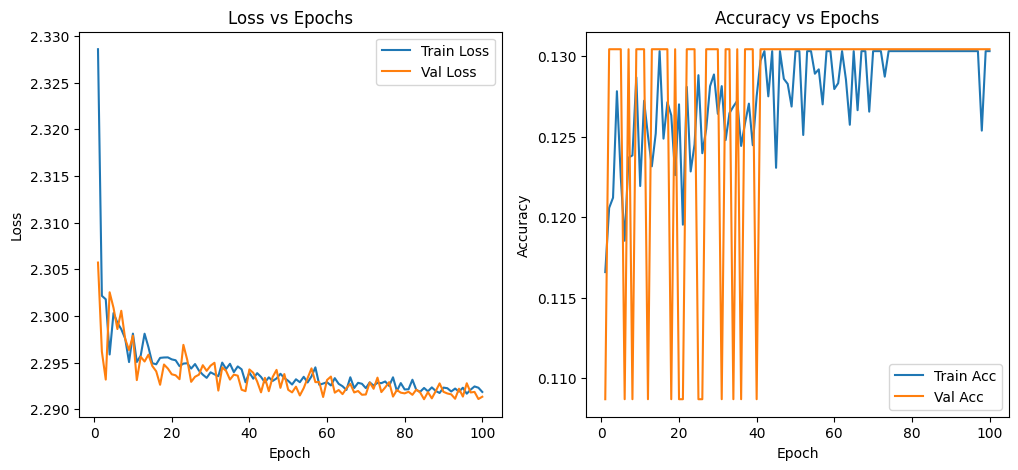

In [11]:
# Cell 10: Training/validation loop with metrics tracking and learning curves plot

from tqdm import tqdm
import matplotlib.pyplot as plt

NUM_EPOCHS = 100  # Set this >1 for meaningful curves!
best_val_acc = 0.0

# Store history
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(NUM_EPOCHS):
    # --- Training ---
    model.train()
    train_loss, correct, total = 0., 0, 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(pixel_values)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * pixel_values.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += pixel_values.size(0)
    avg_train_loss = train_loss / total
    train_acc = correct / total
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # --- Validation ---
    model.eval()
    val_loss, correct, total = 0., 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            logits = model(pixel_values)
            loss = criterion(logits, labels)
            val_loss += loss.item() * pixel_values.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += pixel_values.size(0)
    avg_val_loss = val_loss / total
    val_acc = correct / total
    print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save history
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)

    # Save best model (optional)
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), "best_prithvi_eurosat.pt")
        best_val_acc = val_acc
        print("Saved new best model.")

print("Training complete!")

# Plot learning curves!
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()

In [12]:
# Cell 11: Evaluate on the test set

from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Load the best model checkpoint (saved during validation)
model.load_state_dict(torch.load("best_prithvi_eurosat.pt"))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        logits = model(pixel_values)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += pixel_values.size(0)
test_acc = correct / total
print("Test accuracy:", test_acc)

Test: 100%|██████████| 6/6 [00:13<00:00,  2.22s/it]

Test accuracy: 0.13043478260869565


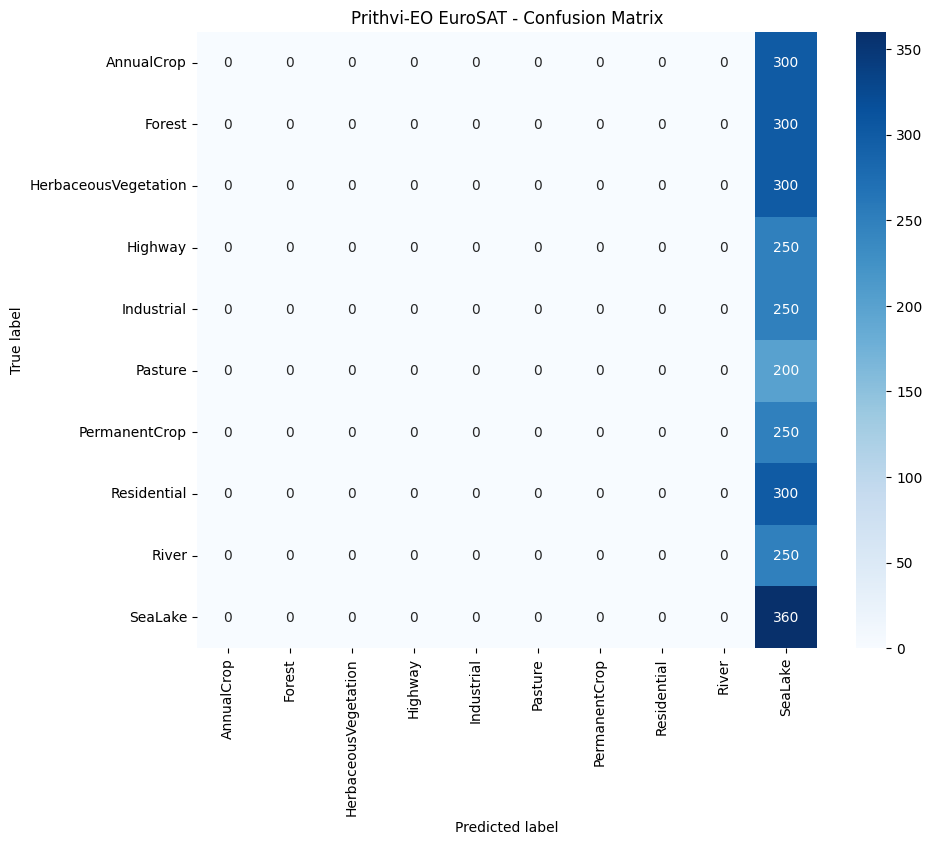

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=list(label2id.keys()), 
            yticklabels=list(label2id.keys()), cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Prithvi-EO EuroSAT - Confusion Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


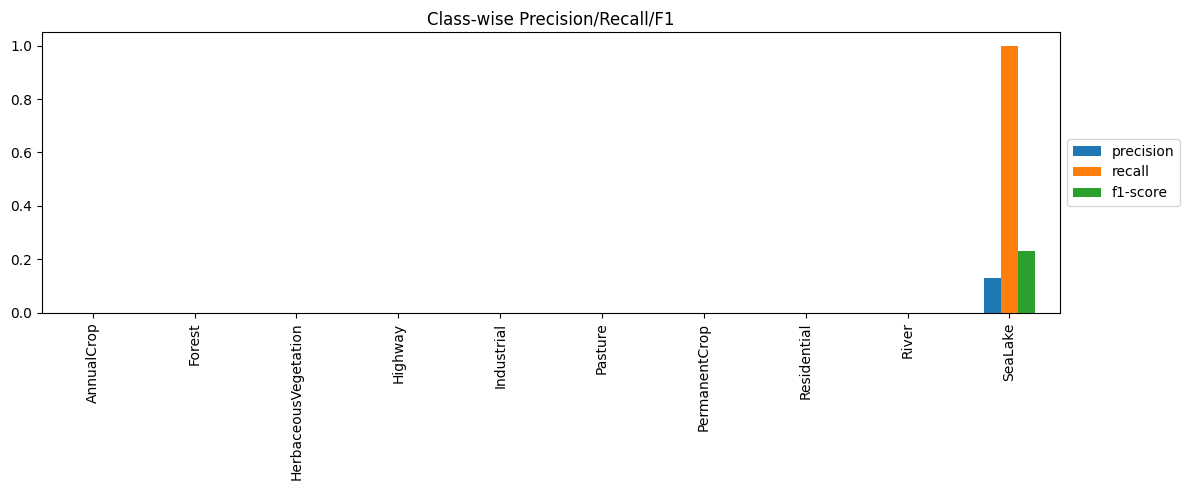

In [14]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(all_labels, all_preds, target_names=list(label2id.keys()), output_dict=True)
df_report = pd.DataFrame(report).T

ax = df_report.iloc[:-3][['precision', 'recall', 'f1-score']].plot(
    kind='bar', figsize=(12,5)
)
plt.title("Class-wise Precision/Recall/F1")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

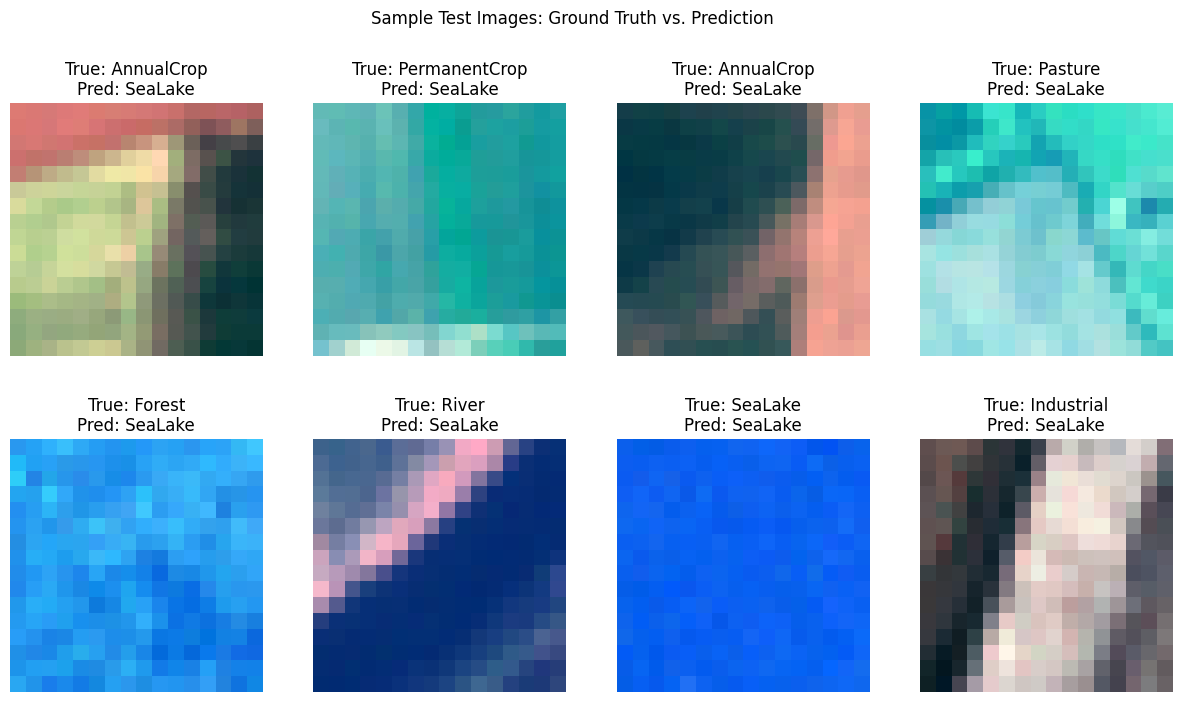

In [15]:
import random
import rasterio

idxs = random.sample(range(len(test_dataset)), 8)
plt.figure(figsize=(15,8))
for i, idx in enumerate(idxs):
    sample = test_dataset[idx]
    img = sample['pixel_values'].numpy()  # (6, 64, 64)
    # Convert to RGB for display (bands 2,3,4 ≈ G,R,B for Sentinel-2 convention)
    img_disp = img[[2,1,0],:,:]  # This may differ if your bands are ordered differently
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())  # Normalize to 0..1
    img_disp = np.transpose(img_disp, (1,2,0))
    pred = model(sample['pixel_values'].unsqueeze(0).to(device)).argmax(dim=1).item()
    plt.subplot(2,4,i+1)
    plt.imshow(img_disp)
    plt.title(f"True: {id2label[sample['labels'].item()]}\nPred: {id2label[pred]}")
    plt.axis('off')
plt.suptitle("Sample Test Images: Ground Truth vs. Prediction")
plt.show()

In [16]:
from IPython.display import FileLink

# First, ensure the file is saved in your working directory.
MODEL_FILENAME = "best_prithvi_eurosat.pt"

# Create a downloadable link
display(FileLink(MODEL_FILENAME))

/kaggle/working/best_prithvi_eurosat.pt